# Titanic Spaceship

Kaggle is well known for their infamous Titanic Competition. In that competition, the goal is to predict whether or not a passenger survived or did not. For this project playground exercise, Kaggle created a new, but similar project that takes place in the future year of 2912. 

While the Spaceship Titanic was traveling on its maiden voyage of transporting 13,000 passengers to three newly habitable exoplanets, the Spaceship Titanic collided with a spacetime anomly. Luckily no one died, but almost half of the passengers were transported to an alternate dimension.

In this project, we will utilize the given data features, clean the given data, fill null values, and engineer additional features to help us implement Machine Learning algorithms to see if we can predict whether a passenger was transported or not.

Let's begin by reading in the data and exploring a bit.

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
space_train = pd.read_csv('train.csv')
space_test = pd.read_csv('test.csv')

In [3]:
print(space_train.isnull().sum())
print('-'*40)
print(space_train.info())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64


In [4]:
space_train['Transported'].value_counts(normalize=True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

Here we can see that there are a fair amount of null values and 8693 total rows of data. We can also see that the training target is fairly balanced at a pretty much 50/50 split.

Filling the null values will be important, so let's take a look to see if we can uncover any patterns. Let's take a look at the first 5 rows to get better acquainted with the data.

In [5]:
space_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Feature Engineering and Filling Null Values

Looking at the data, we can see some potential areas to focus on. We would want to focus on patterns to see if we can fill some null values, also, utlizing the data, we can engineer additional features. Lastly, we can visualize some count plots based on transported to see some preliminary feature importance.

We can begin by some initial feature engineering that will help us extract more information and uncover some patterns. Upon inspecting the data dictionary, we can learn that the following holds true for these two columns:

<code>'PassengerId'</code> - "A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always."

<code>'Cabin'</code> - "The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard."

Using this information, we can split and extract those columns to create additional features. Knowing that not all groups are families, we can separate out the last name and in combination with the group, we can fill null values and create a <code>'Family'</code> feature.

Lastly, we can add a <code>'Total_Spend'</code> column, that aggregates all of the money spent on special services onboard. 

In [6]:
def add_prelim_features(df):
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['Side'] = df['Cabin'].str.split('/').str[2]
    
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['Last_Name'] = df['Name'].str.split().str[1]
    
    df['Family'] = np.NaN
    df['Family'] = df[df.duplicated(subset = ['Last_Name','Group'], keep = False
                                   )]['Family'].fillna(1)
    df['Family'] = df['Family'].fillna(0)

    df['Total_Spend'] = ((df['RoomService'].fillna(0)) +
            (df['FoodCourt'].fillna(0)) +
            (df['ShoppingMall'].fillna(0)) +
            (df['Spa'].fillna(0)) +
            (df['VRDeck'].fillna(0)))
    
    return df

In [7]:
visualize_train = space_train.copy()
visualize_train = add_prelim_features(visualize_train)
visualize_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,Group,Last_Name,Family,Total_Spend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0001,Ofracculy,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,0002,Vines,0.0,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,0003,Susent,1.0,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,0003,Susent,1.0,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,0004,Santantines,0.0,1091.0


Now that we have both <code>'Group'</code> and <code>'Last_Name'</code> added in, we can fill some null values within these families, as well as, based on total spent.

In [8]:
def fill_family_and_spent_nan(df):
    df['HomePlanet'].fillna(df.groupby(
        ['Last_Name','Group'])['HomePlanet'].transform('first'),inplace=True)
    
    df['CryoSleep'].fillna(df.groupby(
        ['Last_Name','Group'])['CryoSleep'].transform('first'),inplace=True)
    
    df['Cabin'].fillna(df.groupby(
        ['Last_Name','Group'])['Cabin'].transform('first'),inplace=True)
    
    df['Deck'].fillna(df.groupby(
    ['Last_Name','Group'])['Deck'].transform('first'),inplace=True)
    
    df['Side'].fillna(df.groupby(
        ['Last_Name','Group'])['Side'].transform('first'),inplace=True)
    
    df['Destination'].fillna(df.groupby(
        ['Last_Name','Group'])['Destination'].transform('first'),inplace=True)
    
    df['VIP'].fillna(df.groupby(
        ['Last_Name','Group'])['VIP'].transform('first'),inplace=True)
    
    df.loc[(df['Total_Spend'] == 0
                     ) & (df['CryoSleep'].isnull()),'CryoSleep'] = True
    
    df.loc[(df['CryoSleep'].isnull()),'CryoSleep'] = False
    
    df.loc[(df['CryoSleep'] == True),['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = 0
    
    return df

In [9]:
visualize_train = fill_family_and_spent_nan(visualize_train)
visualize_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,Group,Last_Name,Family,Total_Spend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0001,Ofracculy,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,0002,Vines,0.0,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,0003,Susent,1.0,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,0003,Susent,1.0,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,0004,Santantines,0.0,1091.0


In [10]:
visualize_train.isnull().sum()

PassengerId       0
HomePlanet      120
CryoSleep         0
Cabin           110
Destination     113
Age             179
VIP             124
RoomService     113
FoodCourt       112
ShoppingMall    109
Spa             117
VRDeck          121
Name            200
Transported       0
Deck            110
Side            110
Group             0
Last_Name       200
Family            0
Total_Spend       0
dtype: int64

## Visualizing the Data

Now that we have begun to fill some null values and create some additional features. We can visualize a bit further to understand the dataset and look for patterns and feature importance.

Let's start with some basic count plots.

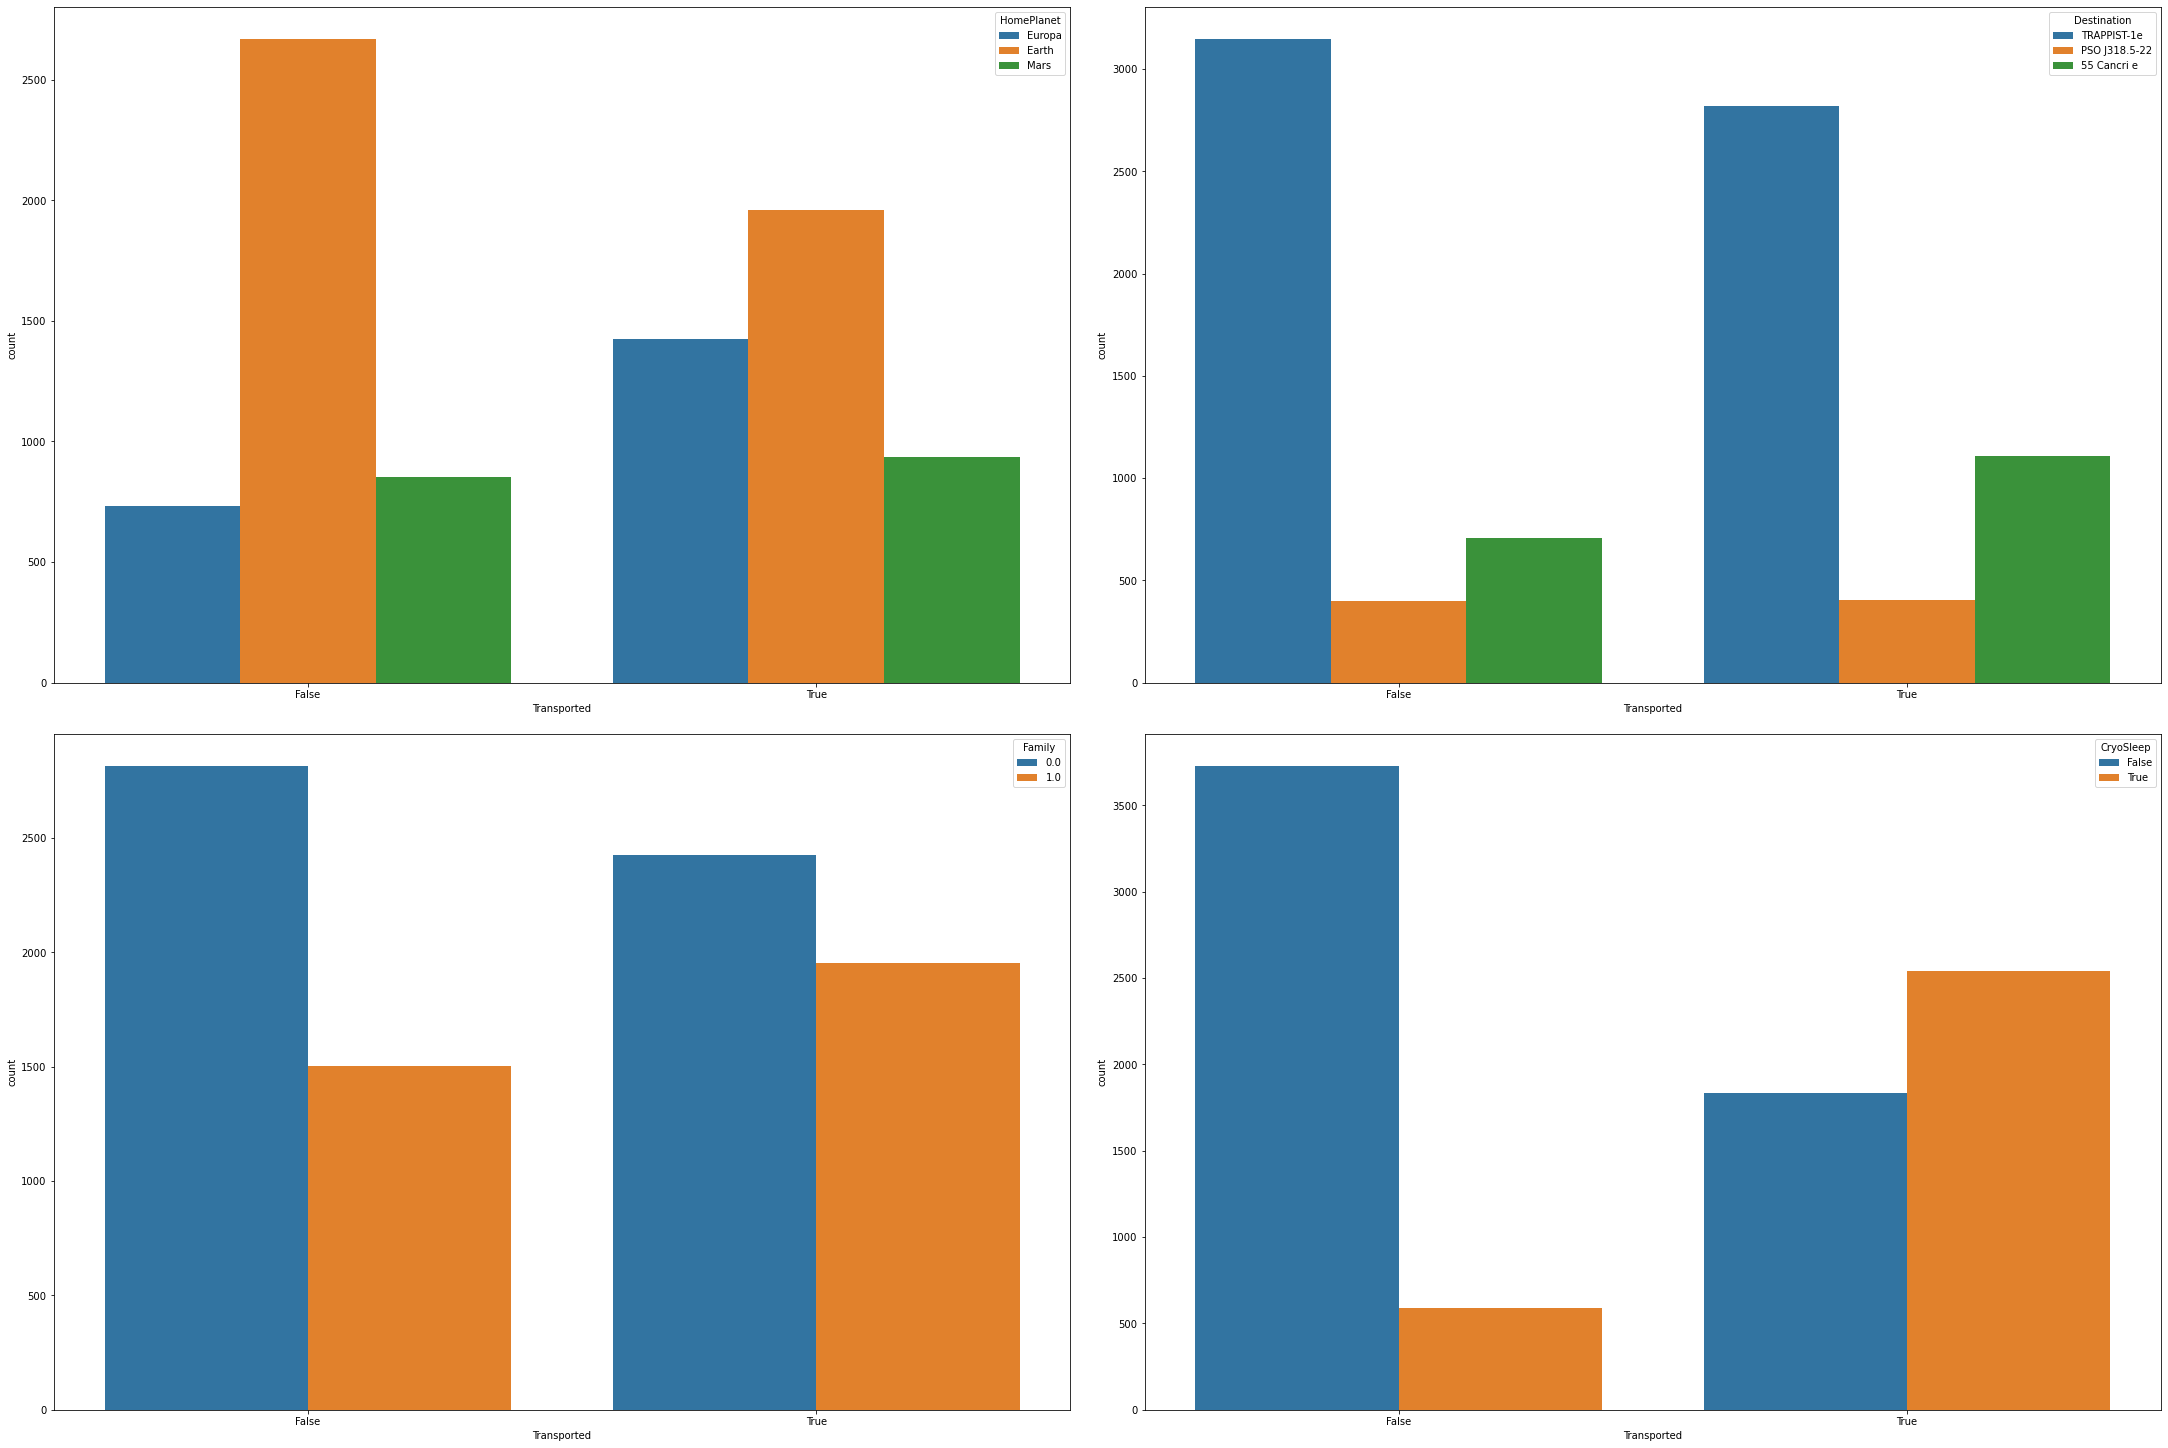

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(30, 20),constrained_layout=True)
sns.countplot(x = visualize_train['Transported'],hue = visualize_train['HomePlanet'], ax = ax[0,0])
sns.countplot(x = visualize_train['Transported'],hue = visualize_train['Destination'],ax = ax[0,1])
sns.countplot(x = visualize_train['Transported'],hue = visualize_train['Family'], ax = ax[1,0])
sns.countplot(x = visualize_train['Transported'],hue = visualize_train['CryoSleep'],ax = ax[1,1])

In [12]:
print(visualize_train['CryoSleep'].value_counts())
print('-'*40)
print(visualize_train['HomePlanet'].value_counts())

False    5561
True     3132
Name: CryoSleep, dtype: int64
----------------------------------------
Earth     4629
Europa    2159
Mars      1785
Name: HomePlanet, dtype: int64


It seems that potentially whether or not the passenger was in CyroSleep or where their Hometown was could potentially affect whether or not they were transported or not. However, this could also be explained based on where the passenger was in terms of location on the ship itself. It could also, be unrelated.

Let's explore a few more.

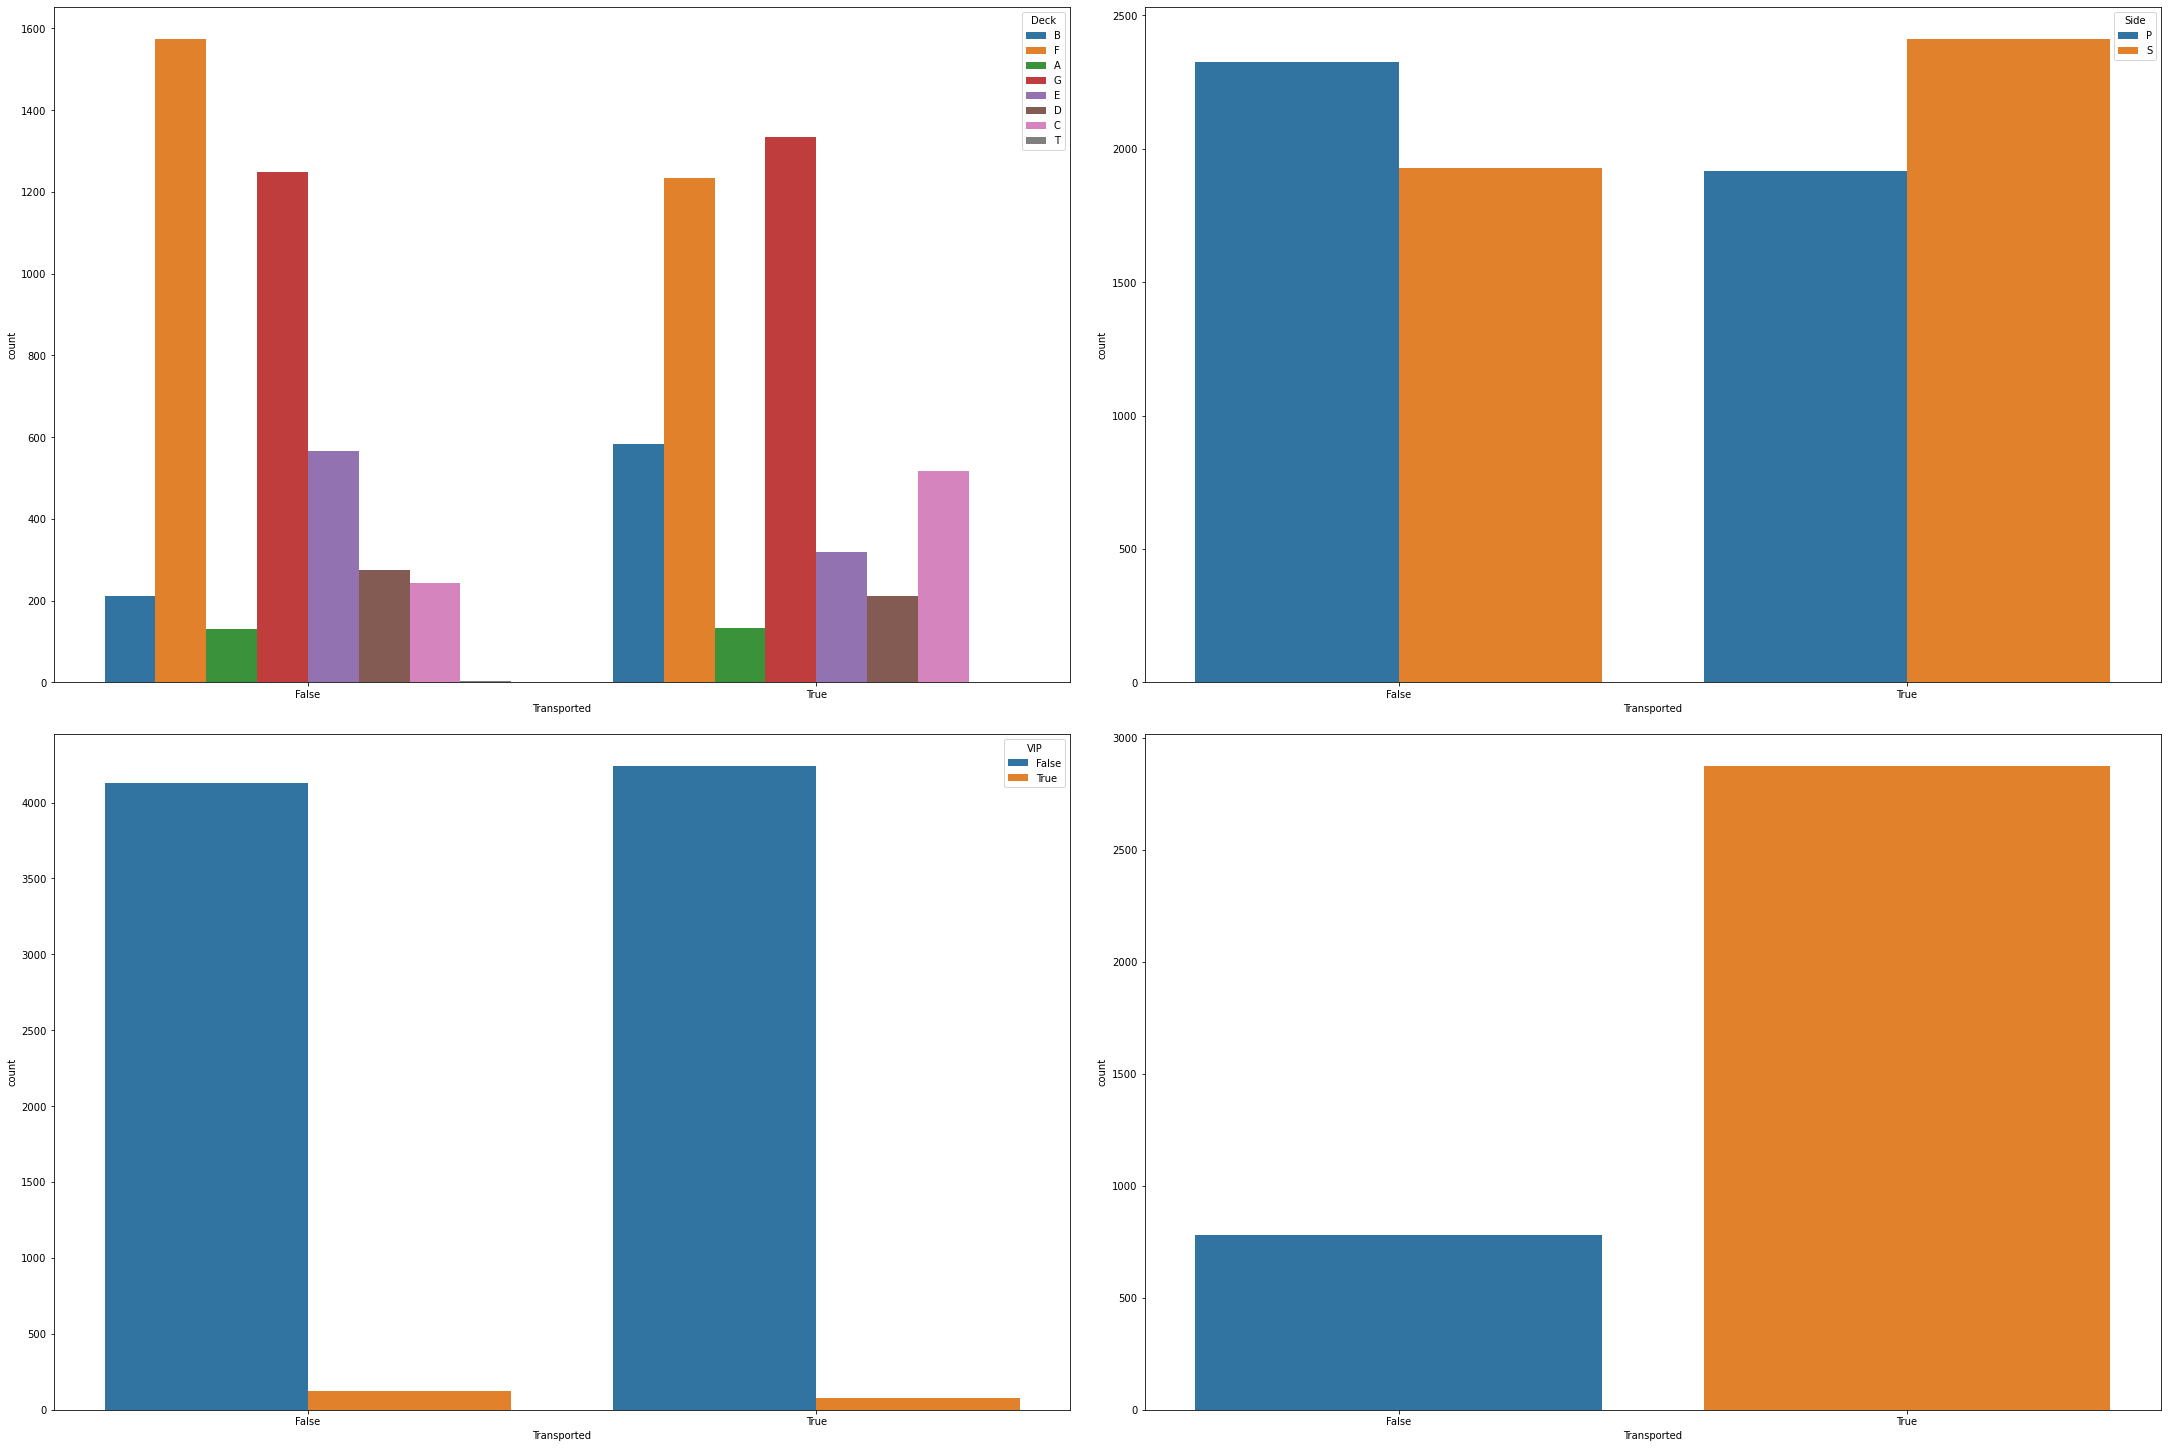

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(30, 20),constrained_layout=True)
sns.countplot(x = visualize_train['Transported'],hue = visualize_train['Deck'], ax = ax[0,0])
sns.countplot(x = visualize_train['Transported'],hue = visualize_train['Side'],ax = ax[0,1])
sns.countplot(x = visualize_train['Transported'],hue = visualize_train['VIP'], ax = ax[1,0])
sns.countplot(x = visualize_train[visualize_train['Total_Spend'] == 0]['Transported'],ax = ax[1,1])

Here there seems to be a variance amongst the Deck location, but the big eye opener is that when the dataset is filtered on passengers that spent no money, there is a huge difference in <code>'Transported'</code>. 

Let's take a further look at that.

In [14]:
visualize_train[visualize_train['Total_Spend'] == 0]['Transported'].value_counts(normalize=True)

True     0.786477
False    0.213523
Name: Transported, dtype: float64

Wow! Although the target in the dataset is balanced with a 50/50 split, if we just make simple predictions based on the passenger being transported if they spent no money onboard, we'd be 78% accurate.

## Patterns for Null Values
Now that we've explored a bit further in the data, let's see if we can uncover some additional patterns that will help us finalize filling the null values.

I've spent a great deal of time finding patterns to fill the null values, so the next function will contain a lot of NaN filling. I'll show just a few examples to help illlustrate thought my thought process. 

Based on the count plots above, I realized <code>'HomePlanet'</code> and <code>'Deck'</code> both displayed indicators for passengers being transported. This could be an avenue for patterns. Let's look.

In [15]:
for i in ['A','B','C','T','G']:
    print('Deck: ',i)
    print(visualize_train[visualize_train['Deck'] == i]['HomePlanet'].value_counts())
    print('-'*20)

Deck:  A
Europa    260
Name: HomePlanet, dtype: int64
--------------------
Deck:  B
Europa    794
Name: HomePlanet, dtype: int64
--------------------
Deck:  C
Europa    756
Name: HomePlanet, dtype: int64
--------------------
Deck:  T
Europa    4
Name: HomePlanet, dtype: int64
--------------------
Deck:  G
Earth    2540
Name: HomePlanet, dtype: int64
--------------------


Here we can see that based on the <code>'Deck'</code> location, <code>'HomePlanet'</code> had 100% occupancy.

Another potential correlation could be that money spent could be an indicator for <code>'VIP'</code> status, so we can look at descriptive statistics to see if there are major differences.

In [16]:
visualize_train[visualize_train['VIP'] == True].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Family,Total_Spend
count,199.000000,196.000000,195.000000,195.000000,199.000000,197.000000,200.000000,200.000000
mean,37.407035,471.173469,1778.046154,246.456410,751.371859,1222.299492,0.485000,4412.435000
std,11.598073,1096.076935,3739.171590,586.201921,1615.917147,2443.676725,0.501029,5111.745411
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1283.500000
50%,34.000000,0.000000,280.000000,0.000000,35.000000,27.000000,0.000000,2755.000000
75%,44.000000,527.750000,2103.000000,153.000000,831.500000,1367.000000,1.000000,6077.750000
max,73.000000,8243.000000,29813.000000,3700.000000,13902.000000,12424.000000,1.000000,31076.000000


In [17]:
visualize_train[visualize_train['VIP'] == False].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Family,Total_Spend
count,8196.000000,8262.000000,8262.000000,8267.000000,8253.000000,8251.000000,8369.000000,8369.000000
mean,28.598707,216.044783,420.879448,170.286319,298.175451,281.220458,0.400765,1376.757080
std,14.501567,650.946488,1500.610108,604.915654,1120.344105,1088.263194,0.490083,2696.744564
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,705.000000
75%,38.000000,39.000000,52.000000,23.000000,49.000000,37.000000,1.000000,1370.000000
max,79.000000,14327.000000,27071.000000,23492.000000,22408.000000,24133.000000,1.000000,35987.000000


Here we can easily see that both the mean values and 75% percentiles are greatly different between the two VIP status. We can use this to fill null values, and given that money spent is a major indicator of a passengers transported status, we can use it the reverse way as well.

Looking at the max values, we can see that there are some potential major outliers. Let's take a look.

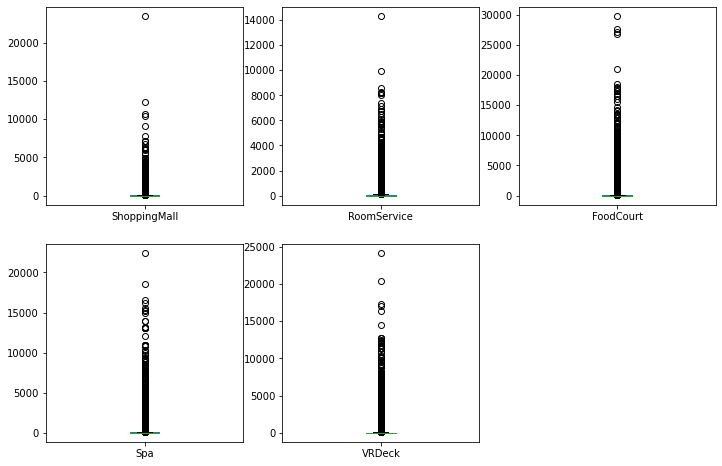

In [18]:
plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
visualize_train['ShoppingMall'].plot.box()

plt.subplot(2,3,2)
visualize_train['RoomService'].plot.box()

plt.subplot(2,3,3)
visualize_train['FoodCourt'].plot.box()

plt.subplot(2,3,4)
visualize_train['Spa'].plot.box()

plt.subplot(2,3,5)
visualize_train['VRDeck'].plot.box()

There are indeed outliers, but since we found <code>'Total_Spend'</code> to be such an indicator, I plan to bin everything. I already explored these outliers and they didn't seem to be an error.

## Final Dataset Cleaning
Now that I showed a bit of my pattern uncovering, let's go ahead and run the full function to fill null values.

In [19]:
def fill_na_stats(df):
    # DECK A,B,C,T 100% Europa, DECK G 100% Earth
    df.loc[((df['Deck'] == 'A') | 
           (df['Deck'] == 'B') |
           (df['Deck'] == 'C') |
           (df['Deck'] == 'T')) &
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Europa'
    
    df.loc[(df['Deck'] == 'G') & (df['HomePlanet'].isnull()),'HomePlanet'] = 'Earth'
    
    # DECK E ~80% Trappist
    df.loc[(df['Deck'] == 'E')
                 &(df['Destination'].isnull()),'Destination'] = 'TRAPPIST-1e'
    # DECK F ~75% Trappist
    df.loc[(df['Deck'] == 'F') & 
           (df['Destination'].isnull()),'Destination'] = 'TRAPPIST-1e'  
    
    # DEck T 100% trap
    df.loc[(df['Deck'] == 'T') & 
           (df['Destination'].isnull()),'Destination'] = 'TRAPPIST-1e'
    
    #VIP FALSE F(33%),G,E,B,C,D,A,T
    #VIP TRUE C,B,A,D,F(15% - 100% Mars),E - NO G or T
    # VIP NULL F (41%), G (34%), E, C, B, D, A
    
    df.loc[((df['Deck'] == 'T') |
           (df['Deck'] == 'G')) &
           (df['VIP'].isnull()),'VIP'] = True
    
    df.loc[(df['Deck'] == 'F') &
           (df['HomePlanet'] == 'Mars') &
           (df['VIP'].isnull()),'VIP'] = True
    
    df.loc[(df['Deck'] == 'F') &
       (df['HomePlanet'] != 'Mars') &
       (df['VIP'].isnull()),'VIP'] = False
    
    df.loc[(df['Deck'] == 'F') & 
           (df['VIP'] == True),'HomePlanet'] == 'Mars'
    
    df.loc[((df['RoomService'] > 800) |
           (df['FoodCourt'] > 1000) |
           (df['Spa'] > 800) |
           (df['VRDeck'] > 800)) &
           (df['VIP'].isnull()),'VIP'] = True
    
    df.loc[(df['ShoppingMall'] > 300) &
           (df['HomePlanet'] == 'Earth') &
           (df['VIP'].isnull()),'VIP'] = False  
    
    df.loc[(df['VRDeck'] > 300) &
           (df['HomePlanet'] == 'Earth') &
           (df['VIP'].isnull()),'VIP'] = False   

    df.loc[(df['Destination'] == 'PSO J318.5-22') &
           (df['HomePlanet'] == 'Mars') & 
            (df['RoomService'] > 700) &
           (df['VIP'].isnull()),'VIP'] = False  
    
    df.loc[1464,'VIP'] = True
    
    df['VIP'].fillna(False,inplace=True)
    
    df.loc[(df['Deck'] == 'F') & 
           (df['CryoSleep'] == True) & 
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Mars'
    
    df.loc[(df['Deck'] == 'F') & 
           (df['CryoSleep'] == False) & 
           (df['VIP'] == True) &
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Mars'
    
    df.loc[(df['Deck'] == 'F') & 
           (df['CryoSleep'] == False) & 
           (df['VIP'] == False) &
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Earth'

    df.loc[(df['Deck'] == 'D') & 
           (df['CryoSleep'] == True) & 
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Europa'
    
    df.loc[(df['Deck'] == 'D') & 
           (df['CryoSleep'] == False) & 
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Mars'
           
    df.loc[(df['Deck'] == 'E') & 
           (df['CryoSleep'] == False) & 
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Earth'
    
    df.loc[(df['Deck'] == 'E') & 
           (df['CryoSleep'] == True) & 
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Mars'
    
    df.loc[(df['Destination'] == '55 Cancri e') & 
           (df['CryoSleep'] == True) & 
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Europa'
    
    df.loc[(df['Destination'] == '55 Cancri e') & 
           (df['CryoSleep'] == False) & 
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Earth'

    df.loc[(df['Destination'] == 'TRAPPIST-1e') & 
           (df['HomePlanet'].isnull()),'HomePlanet'] = 'Earth'
    
    df.loc[((df['Deck'] == 'G') | (df['Deck'] == 'D')) &
           (df['Destination'].isnull()),'Destination'] = 'TRAPPIST-1e'
    
    df.loc[(df['Deck'] == 'C') & 
           (df['CryoSleep'] == True) & 
           (df['Destination'].isnull()),'Destination'] = '55 Cancri e'
    
    df.loc[(df['Deck'] == 'C') & 
       (df['CryoSleep'] == False) & 
       (df['Destination'].isnull()),'Destination'] = 'TRAPPIST-1e'
    
    df.loc[(df['Deck'] == 'A') & 
           (df['CryoSleep'] == True) & 
           (df['Destination'].isnull()),'Destination'] = '55 Cancri e'

    df.loc[(df['HomePlanet'] == 'Europa') & 
       (df['Destination'].isnull()),'Destination'] = 'TRAPPIST-1e'
    
    df.loc[(df['HomePlanet'] == 'Earth') & 
           (df['CryoSleep'] == True) & 
           (df['Deck'].isnull()), 'Deck'] = 'G'
    
    df.loc[(df['HomePlanet'] == 'Earth') & 
           (df['CryoSleep'] == False) & 
           (df['Deck'].isnull()), 'Deck'] = 'F'
    
    df.loc[(df['HomePlanet'] == 'Mars') & 
           (df['Deck'].isnull()), 'Deck'] = 'F'
    
    #Europa + Cryosleep B46 C32, Europa + NO Sleep C37,B29
    df.loc[(df['HomePlanet'] == 'Europa') & 
           (df['CryoSleep'] == True) & 
           (df['Deck'].isnull()), 'Deck'] = 'B'
    
    df.loc[(df['HomePlanet'] == 'Europa') & 
           (df['CryoSleep'] == False) & 
           (df['Deck'].isnull()), 'Deck'] = 'C'
    
    #A S-53,P-46, #B S-54, P-45, #C S-54, P-45, #D P-52, S-47, #E S-51, P-48, #F P-51, S-48, #G 5050, 
    df.loc[((df['Deck'] == 'A') | 
           (df['Deck'] == 'B') | 
           (df['Deck'] == 'C') | 
           (df['Deck'] == 'E') | 
           (df['Deck'] == 'G')) &
           (df['Side'].isnull()),'Side'] = 'S'
    
    df['Side'].fillna('P',inplace=True)
    
    df.loc[(df['Deck'] == 'F') & 
       (df['Destination'].isnull()),'Destination'] = 'TRAPPIST-1e' 

    return df

In [20]:
visualize_train = fill_na_stats(visualize_train)
visualize_train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           110
Destination       0
Age             179
VIP               0
RoomService     113
FoodCourt       112
ShoppingMall    109
Spa             117
VRDeck          121
Name            200
Transported       0
Deck              0
Side              0
Group             0
Last_Name       200
Family            0
Total_Spend       0
dtype: int64

## Additional Feature Engineering with Binning

Now that most of the features that we care have the null values filled besides money spent on services, let's go ahead and work on that by placing everything in bins. I already worked up the split points using descriptive statistics.

In [21]:
def bins(df):
    df['Age'] = df['Age'].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ['Missing','Infant','Child','Teenager','Young Adult','Adult','Senior']
    df['Age_categories'] = pd.cut(df['Age'],cut_points,labels=label_names)

    bin_labels_1 = ['0 Dollars','65+_percentile_group','75+_percentile_group', '80+_percentile_group', '85+_percentile_group'
                    ,'90+_percentile_group','95+_percentile_group']

    df['RoomService_Bin'] = pd.cut(df['RoomService'].dropna(),
                          [-1,0,42,164,434,747,1257,14327],
                          labels=bin_labels_1)
    
    df['RoomService_Bin'].cat.add_categories('Unknown',inplace=True)
    df['RoomService_Bin'].fillna('Unknown',inplace=True)
    
    df['FoodCourt_Bin'] = pd.cut(df['FoodCourt'].dropna(),
                      [-1,0,66,242,595,995,2673,29813],
                      labels=bin_labels_1)
    
    df['FoodCourt_Bin'].cat.add_categories('Unknown',inplace=True)
    df['FoodCourt_Bin'].fillna('Unknown',inplace=True)

    df['ShoppingMall_Bin'] = pd.cut(df['ShoppingMall'].dropna(),
                      [-1,0,22,90,290,611,920,23492],
                      labels=bin_labels_1)

    df['ShoppingMall_Bin'].cat.add_categories('Unknown',inplace=True)
    df['ShoppingMall_Bin'].fillna('Unknown',inplace=True)

    df['Spa_Bin'] = pd.cut(df['Spa'].dropna(),
                      [-1,0,55,172,414,724,1588,22408],
                      labels=bin_labels_1)

    df['Spa_Bin'].cat.add_categories('Unknown',inplace=True)
    df['Spa_Bin'].fillna('Unknown',inplace=True)

    df['VRDeck_Bin'] = pd.cut(df['VRDeck'].dropna(),
                      [-1,0,41,144,396,721,1499,24133],
                      labels=bin_labels_1)
    
    df['VRDeck_Bin'].cat.add_categories('Unknown',inplace=True)
    df['VRDeck_Bin'].fillna('Unknown',inplace=True)
  
    bin_labels_2 = ['0 Dollars','50+_percentile_group','60+_percentile_group',
                    '75+_percentile_group', '80+_percentile_group', '85+_percentile_group'
                    ,'90+_percentile_group','95+_percentile_group']
    
    df['Total_Spend_Bin'] = pd.cut(df['Total_Spend'].dropna(),
                  [-1,0,716,1440,1872,2597,3837,6456,35987],
                  labels=bin_labels_2,precision=0)

    df['Total_Spend_Bin'].cat.add_categories('Unknown',inplace=True)
    df['Total_Spend_Bin'].fillna('Unknown',inplace=True)

    return df

In [22]:
visualize_train = bins(visualize_train)

In [23]:
print(visualize_train.isnull().sum())
visualize_train.head()

PassengerId           0
HomePlanet            0
CryoSleep             0
Cabin               110
Destination           0
Age                   0
VIP                   0
RoomService         113
FoodCourt           112
ShoppingMall        109
Spa                 117
VRDeck              121
Name                200
Transported           0
Deck                  0
Side                  0
Group                 0
Last_Name           200
Family                0
Total_Spend           0
Age_categories        0
RoomService_Bin       0
FoodCourt_Bin         0
ShoppingMall_Bin      0
Spa_Bin               0
VRDeck_Bin            0
Total_Spend_Bin       0
dtype: int64


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,Group,Last_Name,Family,Total_Spend,Age_categories,RoomService_Bin,FoodCourt_Bin,ShoppingMall_Bin,Spa_Bin,VRDeck_Bin,Total_Spend_Bin
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0001,Ofracculy,0.0,0.0,Adult,0 Dollars,0 Dollars,0 Dollars,0 Dollars,0 Dollars,0 Dollars
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,0002,Vines,0.0,736.0,Young Adult,75+_percentile_group,65+_percentile_group,75+_percentile_group,85+_percentile_group,75+_percentile_group,60+_percentile_group
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,0003,Susent,1.0,10383.0,Adult,75+_percentile_group,95+_percentile_group,0 Dollars,95+_percentile_group,75+_percentile_group,95+_percentile_group
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,0003,Susent,1.0,5176.0,Young Adult,0 Dollars,90+_percentile_group,85+_percentile_group,95+_percentile_group,80+_percentile_group,90+_percentile_group
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,0004,Santantines,0.0,1091.0,Teenager,80+_percentile_group,75+_percentile_group,80+_percentile_group,85+_percentile_group,65+_percentile_group,60+_percentile_group


## Setting up Dataframe for Machine Learning
With everything cleaned, filled, and finalized, the last step will be to drop the columns we don't need, and create dummy values to help our machine learning algorithms running more efficiently.

We'll now run everything on the original training and test set and being the predictive modeling.

In [24]:
def drop_cols(df):
    df.drop(['Cabin','RoomService','FoodCourt','ShoppingMall','Spa',
             'VRDeck','Name','Last_Name','Age','Group','Total_Spend'],
           axis = 1,inplace=True)
    df.set_index('PassengerId',inplace=True)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def process_df(df,train=True):
    #df = df.copy()
    df = add_prelim_features(df)
    df = fill_family_and_spent_nan(df)
    df = fill_na_stats(df)
    df = bins(df)
    df = drop_cols(df)
    if train == True:
        dummy_columns = df.columns.drop('Transported')
        #df['Transported'] = df['Transported'].astype('str')
    else:
        dummy_columns = df.columns
    for column in dummy_columns:
        df = create_dummies(df,column)

    df.drop(dummy_columns,axis=1,inplace=True)   
    
    return df

In [25]:
space_train_copy = space_train.copy()
space_train_copy = process_df(space_train_copy)
holdout = space_test.copy()
holdout = process_df(holdout, train=False)
print(space_train_copy.isnull().sum())
space_train_copy.head()

Transported                              0
HomePlanet_Earth                         0
HomePlanet_Europa                        0
HomePlanet_Mars                          0
CryoSleep_False                          0
CryoSleep_True                           0
Destination_55 Cancri e                  0
Destination_PSO J318.5-22                0
Destination_TRAPPIST-1e                  0
VIP_False                                0
VIP_True                                 0
Deck_A                                   0
Deck_B                                   0
Deck_C                                   0
Deck_D                                   0
Deck_E                                   0
Deck_F                                   0
Deck_G                                   0
Deck_T                                   0
Side_P                                   0
Side_S                                   0
Family_0.0                               0
Family_1.0                               0
Age_categor

,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Family_0.0,Family_1.0,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,RoomService_Bin_0 Dollars,RoomService_Bin_65+_percentile_group,RoomService_Bin_75+_percentile_group,RoomService_Bin_80+_percentile_group,RoomService_Bin_85+_percentile_group,RoomService_Bin_90+_percentile_group,RoomService_Bin_95+_percentile_group,RoomService_Bin_Unknown,FoodCourt_Bin_0 Dollars,FoodCourt_Bin_65+_percentile_group,FoodCourt_Bin_75+_percentile_group,FoodCourt_Bin_80+_percentile_group,FoodCourt_Bin_85+_percentile_group,FoodCourt_Bin_90+_percentile_group,FoodCourt_Bin_95+_percentile_group,FoodCourt_Bin_Unknown,ShoppingMall_Bin_0 Dollars,ShoppingMall_Bin_65+_percentile_group,ShoppingMall_Bin_75+_percentile_group,ShoppingMall_Bin_80+_percentile_group,ShoppingMall_Bin_85+_percentile_group,ShoppingMall_Bin_90+_percentile_group,ShoppingMall_Bin_95+_percentile_group,ShoppingMall_Bin_Unknown,Spa_Bin_0 Dollars,Spa_Bin_65+_percentile_group,Spa_Bin_75+_percentile_group,Spa_Bin_80+_percentile_group,Spa_Bin_85+_percentile_group,Spa_Bin_90+_percentile_group,Spa_Bin_95+_percentile_group,Spa_Bin_Unknown,VRDeck_Bin_0 Dollars,VRDeck_Bin_65+_percentile_group,VRDeck_Bin_75+_percentile_group,VRDeck_Bin_80+_percentile_group,VRDeck_Bin_85+_percentile_group,VRDeck_Bin_90+_percentile_group,VRDeck_Bin_95+_percentile_group,VRDeck_Bin_Unknown,Total_Spend_Bin_0 Dollars,Total_Spend_Bin_50+_percentile_group,Total_Spend_Bin_60+_percentile_group,Total_Spend_Bin_75+_percentile_group,Total_Spend_Bin_80+_percentile_group,Total_Spend_Bin_85+_percentile_group,Total_Spend_Bin_90+_percentile_group,Total_Spend_Bin_95+_percentile_group,Total_Spend_Bin_Unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0001_01,False,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
0002_01,True,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
0003_01,False,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0003_02,False,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
0004_01,True,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [26]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 78 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   HomePlanet_Earth                       4277 non-null   uint8
 1   HomePlanet_Europa                      4277 non-null   uint8
 2   HomePlanet_Mars                        4277 non-null   uint8
 3   CryoSleep_False                        4277 non-null   uint8
 4   CryoSleep_True                         4277 non-null   uint8
 5   Destination_55 Cancri e                4277 non-null   uint8
 6   Destination_PSO J318.5-22              4277 non-null   uint8
 7   Destination_TRAPPIST-1e                4277 non-null   uint8
 8   VIP_False                              4277 non-null   uint8
 9   VIP_True                               4277 non-null   uint8
 10  Deck_A                                 4277 non-null   uint8
 11  Deck_B                    

## Predictive Modeling
Now that we're all ready for begin, let's implement a baseline that we want to beat. The standard would be better than 50% accuracy since it's a balance dataset, however, since we discovered that if we filter on passengers that spent zero dollars, we can predict that they will be transported with higher accuracy. Now that all the null values have been filled and the feature engineering is complete, let's check our new baseline.

In [27]:
space_train_copy[space_train_copy['Total_Spend_Bin_0 Dollars'] == 1]['Transported'].value_counts(normalize=True)

True     0.786477
False    0.213523
Name: Transported, dtype: float64

78%! This wil be tough to beat. Let's now create our function to submit our prediction to Kaggle to see how our models perform on their holdout set. 

In [28]:
def save_submission_file(model,df,filename='submission.csv'):
    predictions = model.predict(df)
    
    submission = pd.DataFrame({'PassengerId':holdout.index,
                                 'Transported':predictions})
    submission.to_csv(filename,index=False)

In [29]:
features = list(space_train_copy.drop('Transported',axis=1).columns)

target = 'Transported'
X_train, X_test, y_train, y_test = train_test_split(space_train_copy[features], space_train_copy[target]
                                                    , test_size = 0.20, random_state = 1, shuffle=True)

rf = RandomForestClassifier()

rf.fit(X_train,y_train)
train_predictions = rf.predict(X_train)
test_predictions = rf.predict(X_test)

train_rf_acc = accuracy_score(y_train, train_predictions)

test_rf_acc = accuracy_score(y_test, test_predictions)

print('Training Set Accuracy: ',train_rf_acc)

print('Testing Set Accuracy: ',test_rf_acc)

imp = rf.feature_importances_
cols = list(features)
imp_df = pd.DataFrame({"feature": cols, "Importance": imp})
imp_sorted = imp_df.sort_values("Importance", ascending=False)
print('-'*50)
print(imp_sorted.head())

Training Set Accuracy:  0.9282427379925223
Testing Set Accuracy:  0.7843588269120184
--------------------------------------------------
                      feature  Importance
69  Total_Spend_Bin_0 Dollars    0.057055
4              CryoSleep_True    0.054404
3             CryoSleep_False    0.045977
29  RoomService_Bin_0 Dollars    0.045568
61       VRDeck_Bin_0 Dollars    0.040837


It seems that our baseline Random Forest model performs no better than just filtering on zero dollars spent. Let's see once we submit these to Kaggle how they perform on the true holdout set.

In [30]:
X_train = space_train_copy[features]
y_train = space_train_copy[target]
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
    
save_submission_file(rf,holdout,filename='base_rf_submission.csv')

filtered_on_0 = holdout.copy()
filtered_on_0['Transported'] = False
filtered_on_0.loc[filtered_on_0['Total_Spend_Bin_0 Dollars'] == 1, 'Transported'] = True
filtered_on_0 = filtered_on_0['Transported'].reset_index()

filtered_on_0.to_csv('Filtered_on_Zero_Spend.csv',index=False)

Filtered on Zero Spend got us 0.75075, where as the Random Forest baseline got us a 0.7829. Seems like we're on the right track. Let's try out a couple different models like KNN and Logistic Regression with a Grid Search including hyperparameter options for Random Forest.

In [31]:
def select_model(df,features):
    all_X = df[features]
    all_y = df['Transported']
    
    models = [{
        'name':'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'hyperparameters':
        {
            'n_neighbors': range(1,20,2),
            'weights':['distance','uniform'],
            'algorithm':['ball_tree','kd_tree','brute'],
            'p':[1,2]
         }
    },
    {
        'name':'LogisticRegression',
        'estimator': LogisticRegression(max_iter=1000),
        'hyperparameters':
        {
         'solver':['newton-cg','lbfgs','liblinear']   
        }
    },
    {
        'name':'RandomForestClassifier',
        'estimator':RandomForestClassifier(),
        'hyperparameters':
        {
            'n_estimators': [4, 6, 9,15],
            'criterion': ['entropy','gini'],
            'max_depth': [2, 5, 10,None],
            'max_features': ['log2','sqrt'],
            'min_samples_leaf': [1, 5, 8,11],
            'min_samples_split': [2, 3, 5,7]
        }
    }]
    
    for model in models:
        print(model['name'])
        print('-'*20)
        grid = GridSearchCV(model['estimator'],
                           param_grid = model['hyperparameters'],
                           cv = 10)
        grid.fit(all_X, all_y)
        model['best_parameters'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        
        print('Best Parameters: ',model['best_parameters'])
        print('Best Score: ',model['best_score'])
        
    return models

results = select_model(space_train_copy,features)

KNeighborsClassifier
--------------------
Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
Best Score:  0.7778707194158963
LogisticRegression
--------------------
Best Parameters:  {'solver': 'liblinear'}
Best Score:  0.7882259963228972
RandomForestClassifier
--------------------
Best Parameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 15}
Best Score:  0.7876483737417826


Random Forest still seems to perform the best. Let's submit this tuned version to see if there is an improvement.

In [32]:
best_model = results[2]['best_model']
#best_model
save_submission_file(best_model,holdout,filename='tuned_rf_submission.csv')

The tuned Random Forest only got us 0.78372. Barely better than the baseline. Let's try some other models. I already trained multiple version of this XGBoost Classifier and found this one to be the best.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(space_train_copy[features], space_train_copy[target]
                                                    , test_size = 0.20, random_state = 1, shuffle=True)

xgb2 = XGBClassifier(max_depth = None,n_estimators=1000,min_child_weight=1,colsample_bytree=.9,subsample=.9,
                    learning_rate=.3)

xgb2.fit(X_train,y_train,eval_metric="error", eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=10)
train_predictions = xgb2.predict(X_train)
test_predictions = xgb2.predict(X_test)

train_xgb2_acc = accuracy_score(y_train, train_predictions)

test_xgb2_acc = accuracy_score(y_test, test_predictions)

print('Training Set Accuracy: ',train_xgb2_acc)

print('Testing Set Accuracy: ',test_xgb2_acc)

[0]	validation_0-error:0.21657	validation_1-error:0.22829
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.21340	validation_1-error:0.23002
[2]	validation_0-error:0.20866	validation_1-error:0.23002
[3]	validation_0-error:0.20794	validation_1-error:0.23347
[4]	validation_0-error:0.20262	validation_1-error:0.22772
[5]	validation_0-error:0.20060	validation_1-error:0.23002
[6]	validation_0-error:0.20075	validation_1-error:0.23059
[7]	validation_0-error:0.19572	validation_1-error:0.22082
[8]	validation_0-error:0.19356	validation_1-error:0.21737
[9]	validation_0-error:0.19126	validation_1-error:0.21047
[10]	validation_0-error:0.18867	validation_1-error:0.21104
[11]	validation_0-error:0.18594	validation_1-error:0.20299
[12]	validation_0-error:0.18407	validation_1-error:0.20529
[13]	validation_0-error:0.18249	validation_1-error:0.20299
[14]	validation_0-error

In [34]:
save_submission_file(xgb2,holdout,filename='xgb_earlystop_submission.csv')

This one got us a 0.79237! Improvements! Let's try one more. This time we'll use the Catboost Classifier.

In [35]:
space_train_copy['Transported'] = space_train_copy['Transported'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(space_train_copy[features], space_train_copy[target]
                                                    , test_size = 0.20, random_state = 1, shuffle=True)

cat = CatBoostClassifier(learning_rate = 0.01)
cat.fit(X_train,y_train)
train_predictions = cat.predict(X_train)
test_predictions = cat.predict(X_test)

train_cat_acc = accuracy_score(y_train, train_predictions)

test_cat_acc = accuracy_score(y_test, test_predictions)

print('Training Set Accuracy: ',train_cat_acc)

print('Testing Set Accuracy: ',test_cat_acc)

0:	learn: 0.6893153	total: 63.9ms	remaining: 1m 3s
1:	learn: 0.6849798	total: 66.5ms	remaining: 33.2s
2:	learn: 0.6801063	total: 69ms	remaining: 22.9s
3:	learn: 0.6762968	total: 71.4ms	remaining: 17.8s
4:	learn: 0.6721388	total: 74.4ms	remaining: 14.8s
5:	learn: 0.6691073	total: 77ms	remaining: 12.8s
6:	learn: 0.6656413	total: 79.6ms	remaining: 11.3s
7:	learn: 0.6621140	total: 82.3ms	remaining: 10.2s
8:	learn: 0.6575379	total: 85ms	remaining: 9.36s
9:	learn: 0.6536697	total: 87.5ms	remaining: 8.66s
10:	learn: 0.6500447	total: 90.1ms	remaining: 8.1s
11:	learn: 0.6466608	total: 92.6ms	remaining: 7.62s
12:	learn: 0.6427551	total: 95.4ms	remaining: 7.24s
13:	learn: 0.6384172	total: 98.2ms	remaining: 6.92s
14:	learn: 0.6350806	total: 101ms	remaining: 6.63s
15:	learn: 0.6314101	total: 104ms	remaining: 6.38s
16:	learn: 0.6274584	total: 107ms	remaining: 6.16s
17:	learn: 0.6241869	total: 109ms	remaining: 5.96s
18:	learn: 0.6206448	total: 112ms	remaining: 5.79s
19:	learn: 0.6170489	total: 115ms	

209:	learn: 0.4576911	total: 628ms	remaining: 2.36s
210:	learn: 0.4574043	total: 631ms	remaining: 2.36s
211:	learn: 0.4571460	total: 633ms	remaining: 2.35s
212:	learn: 0.4568241	total: 635ms	remaining: 2.35s
213:	learn: 0.4565922	total: 638ms	remaining: 2.34s
214:	learn: 0.4561931	total: 640ms	remaining: 2.34s
215:	learn: 0.4559283	total: 643ms	remaining: 2.33s
216:	learn: 0.4557230	total: 646ms	remaining: 2.33s
217:	learn: 0.4554684	total: 648ms	remaining: 2.32s
218:	learn: 0.4552036	total: 651ms	remaining: 2.32s
219:	learn: 0.4549834	total: 653ms	remaining: 2.31s
220:	learn: 0.4547709	total: 656ms	remaining: 2.31s
221:	learn: 0.4545784	total: 659ms	remaining: 2.31s
222:	learn: 0.4543124	total: 663ms	remaining: 2.31s
223:	learn: 0.4540696	total: 666ms	remaining: 2.31s
224:	learn: 0.4537158	total: 668ms	remaining: 2.3s
225:	learn: 0.4535297	total: 671ms	remaining: 2.3s
226:	learn: 0.4533426	total: 674ms	remaining: 2.3s
227:	learn: 0.4531090	total: 677ms	remaining: 2.29s
228:	learn: 0.4

368:	learn: 0.4292479	total: 1.01s	remaining: 1.74s
369:	learn: 0.4291252	total: 1.02s	remaining: 1.73s
370:	learn: 0.4289991	total: 1.02s	remaining: 1.73s
371:	learn: 0.4288613	total: 1.02s	remaining: 1.73s
372:	learn: 0.4287496	total: 1.03s	remaining: 1.72s
373:	learn: 0.4286051	total: 1.03s	remaining: 1.72s
374:	learn: 0.4285140	total: 1.03s	remaining: 1.72s
375:	learn: 0.4283593	total: 1.03s	remaining: 1.72s
376:	learn: 0.4282356	total: 1.04s	remaining: 1.71s
377:	learn: 0.4281321	total: 1.04s	remaining: 1.71s
378:	learn: 0.4280003	total: 1.04s	remaining: 1.71s
379:	learn: 0.4278286	total: 1.04s	remaining: 1.7s
380:	learn: 0.4277026	total: 1.05s	remaining: 1.7s
381:	learn: 0.4275612	total: 1.05s	remaining: 1.7s
382:	learn: 0.4274690	total: 1.05s	remaining: 1.7s
383:	learn: 0.4273010	total: 1.06s	remaining: 1.69s
384:	learn: 0.4272010	total: 1.06s	remaining: 1.69s
385:	learn: 0.4270051	total: 1.06s	remaining: 1.69s
386:	learn: 0.4269173	total: 1.06s	remaining: 1.69s
387:	learn: 0.42

537:	learn: 0.4115229	total: 1.42s	remaining: 1.22s
538:	learn: 0.4114501	total: 1.43s	remaining: 1.22s
539:	learn: 0.4114017	total: 1.43s	remaining: 1.22s
540:	learn: 0.4112787	total: 1.43s	remaining: 1.21s
541:	learn: 0.4112642	total: 1.43s	remaining: 1.21s
542:	learn: 0.4111979	total: 1.44s	remaining: 1.21s
543:	learn: 0.4111103	total: 1.44s	remaining: 1.21s
544:	learn: 0.4110200	total: 1.44s	remaining: 1.2s
545:	learn: 0.4109584	total: 1.44s	remaining: 1.2s
546:	learn: 0.4109149	total: 1.45s	remaining: 1.2s
547:	learn: 0.4108261	total: 1.45s	remaining: 1.2s
548:	learn: 0.4107463	total: 1.45s	remaining: 1.19s
549:	learn: 0.4106588	total: 1.45s	remaining: 1.19s
550:	learn: 0.4105626	total: 1.46s	remaining: 1.19s
551:	learn: 0.4104973	total: 1.46s	remaining: 1.18s
552:	learn: 0.4104176	total: 1.46s	remaining: 1.18s
553:	learn: 0.4102250	total: 1.46s	remaining: 1.18s
554:	learn: 0.4101244	total: 1.47s	remaining: 1.18s
555:	learn: 0.4100222	total: 1.47s	remaining: 1.17s
556:	learn: 0.40

741:	learn: 0.3963682	total: 1.93s	remaining: 671ms
742:	learn: 0.3963064	total: 1.93s	remaining: 668ms
743:	learn: 0.3962246	total: 1.93s	remaining: 666ms
744:	learn: 0.3961610	total: 1.94s	remaining: 663ms
745:	learn: 0.3961093	total: 1.94s	remaining: 660ms
746:	learn: 0.3960333	total: 1.94s	remaining: 658ms
747:	learn: 0.3959733	total: 1.95s	remaining: 655ms
748:	learn: 0.3959213	total: 1.95s	remaining: 653ms
749:	learn: 0.3958109	total: 1.95s	remaining: 650ms
750:	learn: 0.3957418	total: 1.95s	remaining: 647ms
751:	learn: 0.3956762	total: 1.96s	remaining: 645ms
752:	learn: 0.3956181	total: 1.96s	remaining: 642ms
753:	learn: 0.3955377	total: 1.96s	remaining: 640ms
754:	learn: 0.3954917	total: 1.96s	remaining: 637ms
755:	learn: 0.3954204	total: 1.97s	remaining: 635ms
756:	learn: 0.3953387	total: 1.97s	remaining: 632ms
757:	learn: 0.3952852	total: 1.97s	remaining: 629ms
758:	learn: 0.3952148	total: 1.98s	remaining: 627ms
759:	learn: 0.3951525	total: 1.98s	remaining: 625ms
760:	learn: 

907:	learn: 0.3851903	total: 2.52s	remaining: 256ms
908:	learn: 0.3851260	total: 2.53s	remaining: 253ms
909:	learn: 0.3850653	total: 2.53s	remaining: 250ms
910:	learn: 0.3850131	total: 2.54s	remaining: 248ms
911:	learn: 0.3849410	total: 2.54s	remaining: 245ms
912:	learn: 0.3848893	total: 2.54s	remaining: 242ms
913:	learn: 0.3848254	total: 2.54s	remaining: 240ms
914:	learn: 0.3847618	total: 2.55s	remaining: 237ms
915:	learn: 0.3846600	total: 2.55s	remaining: 234ms
916:	learn: 0.3845862	total: 2.56s	remaining: 231ms
917:	learn: 0.3845011	total: 2.56s	remaining: 229ms
918:	learn: 0.3844348	total: 2.56s	remaining: 226ms
919:	learn: 0.3843061	total: 2.57s	remaining: 223ms
920:	learn: 0.3842403	total: 2.57s	remaining: 220ms
921:	learn: 0.3841826	total: 2.57s	remaining: 218ms
922:	learn: 0.3841007	total: 2.58s	remaining: 215ms
923:	learn: 0.3840250	total: 2.58s	remaining: 212ms
924:	learn: 0.3839877	total: 2.58s	remaining: 209ms
925:	learn: 0.3838890	total: 2.58s	remaining: 207ms
926:	learn: 

In [36]:
save_submission_file(cat,holdout,filename='cat_lr_0-01_submission.csv')

Success! This got us our best Accuracy of 0.80149. Time to retire.

## Conclusion
This Spaceship Titanic competition required quite a bit of data cleaning, null value filling, and feature engineering. At the end of it, with the right model, we were able to beat our baseline on the official holdout set of 75% with 80%. When this was originally submitted. This placed me in the top 300!

For fun, rather than manually filling null values, I also tried using a KNN imputer to fill the null values and surprisingly, the results were very similar. If I chose 11 neighbors for the imputation, the model actually performed slightly better.

# KNN Imputer
To satisfy curiousity, here is the KNN imputed version.

In [37]:
def add_features(df):
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['Side'] = df['Cabin'].str.split('/').str[2]
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['last_name'] = df['Name'].str.split().str[1]
    
    df['total_spend'] = ((df['RoomService'].fillna(0)) +
            (df['FoodCourt'].fillna(0)) +
            (df['ShoppingMall'].fillna(0)) +
            (df['Spa'].fillna(0)) +
            (df['VRDeck'].fillna(0)))
    
    
    return df

def bins(df):
    df['Age'] = df['Age'].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ['Missing','Infant','Child','Teenager','Young Adult','Adult','Senior']
    df['Age_categories'] = pd.cut(df['Age'],cut_points,labels=label_names)

    bin_labels_1 = ['0 Dollars','65+_percentile_group','75+_percentile_group', '80+_percentile_group', '85+_percentile_group'
                    ,'90+_percentile_group','95+_percentile_group']

    df['RoomService_Bin'] = pd.cut(df['RoomService'].dropna(),
                          [-1,0,42,164,434,747,1257,14327],
                          labels=bin_labels_1)
    
    df['RoomService_Bin'].cat.add_categories('Unknown',inplace=True)
    df['RoomService_Bin'].fillna('Unknown',inplace=True)
    
    df['FoodCourt_Bin'] = pd.cut(df['FoodCourt'].dropna(),
                      [-1,0,66,242,595,995,2673,29813],
                      labels=bin_labels_1)
    
    df['FoodCourt_Bin'].cat.add_categories('Unknown',inplace=True)
    df['FoodCourt_Bin'].fillna('Unknown',inplace=True)

    df['ShoppingMall_Bin'] = pd.cut(df['ShoppingMall'].dropna(),
                      [-1,0,22,90,290,611,920,23492],
                      labels=bin_labels_1)

    df['ShoppingMall_Bin'].cat.add_categories('Unknown',inplace=True)
    df['ShoppingMall_Bin'].fillna('Unknown',inplace=True)

    df['Spa_Bin'] = pd.cut(df['Spa'].dropna(),
                      [-1,0,55,172,414,724,1588,22408],
                      labels=bin_labels_1)

    df['Spa_Bin'].cat.add_categories('Unknown',inplace=True)
    df['Spa_Bin'].fillna('Unknown',inplace=True)

    df['VRDeck_Bin'] = pd.cut(df['VRDeck'].dropna(),
                      [-1,0,41,144,396,721,1499,24133],
                      labels=bin_labels_1)
    
    df['VRDeck_Bin'].cat.add_categories('Unknown',inplace=True)
    df['VRDeck_Bin'].fillna('Unknown',inplace=True)
  
    bin_labels_2 = ['0 Dollars','50+_percentile_group','60+_percentile_group',
                    '75+_percentile_group', '80+_percentile_group', '85+_percentile_group'
                    ,'90+_percentile_group','95+_percentile_group']
    
    df['total_spend_Bin'] = pd.cut(df['total_spend'].dropna(),
                  [-1,0,716,1440,1872,2597,3837,6456,35987],
                  labels=bin_labels_2,precision=0)

    df['total_spend_Bin'].cat.add_categories('Unknown',inplace=True)
    df['total_spend_Bin'].fillna('Unknown',inplace=True)

    return df

def drop_cols_2(df):
    df.drop(['RoomService','FoodCourt','ShoppingMall','Spa',
             'VRDeck','Age','Group','total_spend'],
           axis = 1,inplace=True)
    df.set_index('PassengerId',inplace=True)
    return df

def process_df_2(df,train=True):
    if train == True:
        dummy_columns = df.columns.drop('Transported')
        #df['Transported'] = df['Transported'].astype('str')
    else:
        df.drop(['Cabin','last_name','Name'], axis = 1, inplace=True)
        dummy_columns = df.columns
    for column in dummy_columns:
        df = create_dummies(df,column)

    df.drop(dummy_columns,axis=1,inplace=True)   

    return df

space_train_KNN_impute = space_train.copy()
space_train_KNN_impute = add_features(space_train_KNN_impute)
holdout = space_test.copy()
holdout = add_features(holdout)
space_train_KNN_impute.head()
space_train_KNN_impute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Deck          8494 non-null   object 
 15  Side          8494 non-null   object 
 16  Group         8693 non-null   object 
 17  last_name     8493 non-null   object 
 18  total_spend   8693 non-null 

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
space_train_KNN_impute.drop('Cabin',axis=1,inplace=True)
space_train_KNN_impute.drop('last_name',axis=1,inplace=True)
space_train_KNN_impute.drop('Name',axis=1,inplace=True)

space_train_KNN_impute['HomePlanet'] = space_train_KNN_impute['HomePlanet'].astype('str')
space_train_KNN_impute['HomePlanet'] = le.fit_transform(space_train_KNN_impute['HomePlanet'])
space_train_KNN_impute['CryoSleep'] = le.fit_transform(space_train_KNN_impute['CryoSleep'])
space_train_KNN_impute['Deck'] = space_train_KNN_impute['Deck'].astype('str')


space_train_KNN_impute['Deck'] = le.fit_transform(space_train_KNN_impute['Deck'])
space_train_KNN_impute['Side'] = space_train_KNN_impute['Side'].astype('str')


space_train_KNN_impute['Side'] = le.fit_transform(space_train_KNN_impute['Side'])
space_train_KNN_impute['VIP'] = le.fit_transform(space_train_KNN_impute['VIP'])

space_train_KNN_impute['Destination'] = space_train_KNN_impute['Destination'].astype('str')


space_train_KNN_impute['Destination'] = le.fit_transform(space_train_KNN_impute['Destination'])

from sklearn.impute import KNNImputer
knnimputer = KNNImputer(n_neighbors=11)
columns_knn = space_train_KNN_impute.columns.drop('Transported')
knnimputer.fit(space_train_KNN_impute[columns_knn])
space_train_KNN_impute[columns_knn] = knnimputer.transform(space_train_KNN_impute[columns_knn])
space_train_KNN_impute.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side,Group,total_spend
0,101.0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1.0,0.0,1.0,0.0
1,201.0,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,True,5.0,1.0,2.0,736.0
2,301.0,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0,1.0,3.0,10383.0
3,302.0,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0,1.0,3.0,5176.0
4,401.0,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,True,5.0,1.0,4.0,1091.0


In [39]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
 13  Deck          4177 non-null   object 
 14  Side          4177 non-null   object 
 15  Group         4277 non-null   object 
 16  last_name     4183 non-null   object 
 17  total_spend   4277 non-null   float64
dtypes: float64(7), object(11)
me

In [40]:
space_train_KNN_impute = bins(space_train_KNN_impute)
space_train_KNN_impute = drop_cols_2(space_train_KNN_impute)
space_train_KNN_impute = process_df_2(space_train_KNN_impute)

holdout = bins(holdout)
holdout = drop_cols_2(holdout)
holdout = process_df_2(holdout, train = False)

space_train_KNN_impute.head()

,Transported,HomePlanet_0.0,HomePlanet_1.0,HomePlanet_2.0,HomePlanet_3.0,CryoSleep_0.0,CryoSleep_1.0,CryoSleep_2.0,Destination_0.0,Destination_1.0,Destination_2.0,Destination_3.0,VIP_0.0,VIP_1.0,VIP_2.0,Deck_0.0,Deck_1.0,Deck_2.0,Deck_3.0,Deck_4.0,Deck_5.0,Deck_6.0,Deck_7.0,Deck_8.0,Side_0.0,Side_1.0,Side_2.0,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,RoomService_Bin_0 Dollars,RoomService_Bin_65+_percentile_group,RoomService_Bin_75+_percentile_group,RoomService_Bin_80+_percentile_group,RoomService_Bin_85+_percentile_group,RoomService_Bin_90+_percentile_group,RoomService_Bin_95+_percentile_group,RoomService_Bin_Unknown,FoodCourt_Bin_0 Dollars,FoodCourt_Bin_65+_percentile_group,FoodCourt_Bin_75+_percentile_group,FoodCourt_Bin_80+_percentile_group,FoodCourt_Bin_85+_percentile_group,FoodCourt_Bin_90+_percentile_group,FoodCourt_Bin_95+_percentile_group,FoodCourt_Bin_Unknown,ShoppingMall_Bin_0 Dollars,ShoppingMall_Bin_65+_percentile_group,ShoppingMall_Bin_75+_percentile_group,ShoppingMall_Bin_80+_percentile_group,ShoppingMall_Bin_85+_percentile_group,ShoppingMall_Bin_90+_percentile_group,ShoppingMall_Bin_95+_percentile_group,ShoppingMall_Bin_Unknown,Spa_Bin_0 Dollars,Spa_Bin_65+_percentile_group,Spa_Bin_75+_percentile_group,Spa_Bin_80+_percentile_group,Spa_Bin_85+_percentile_group,Spa_Bin_90+_percentile_group,Spa_Bin_95+_percentile_group,Spa_Bin_Unknown,VRDeck_Bin_0 Dollars,VRDeck_Bin_65+_percentile_group,VRDeck_Bin_75+_percentile_group,VRDeck_Bin_80+_percentile_group,VRDeck_Bin_85+_percentile_group,VRDeck_Bin_90+_percentile_group,VRDeck_Bin_95+_percentile_group,VRDeck_Bin_Unknown,total_spend_Bin_0 Dollars,total_spend_Bin_50+_percentile_group,total_spend_Bin_60+_percentile_group,total_spend_Bin_75+_percentile_group,total_spend_Bin_80+_percentile_group,total_spend_Bin_85+_percentile_group,total_spend_Bin_90+_percentile_group,total_spend_Bin_95+_percentile_group,total_spend_Bin_Unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101.0,False,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
201.0,True,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
301.0,False,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
302.0,False,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
401.0,True,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [41]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 76 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   HomePlanet_Earth                       4277 non-null   uint8
 1   HomePlanet_Europa                      4277 non-null   uint8
 2   HomePlanet_Mars                        4277 non-null   uint8
 3   CryoSleep_False                        4277 non-null   uint8
 4   CryoSleep_True                         4277 non-null   uint8
 5   Destination_55 Cancri e                4277 non-null   uint8
 6   Destination_PSO J318.5-22              4277 non-null   uint8
 7   Destination_TRAPPIST-1e                4277 non-null   uint8
 8   VIP_False                              4277 non-null   uint8
 9   VIP_True                               4277 non-null   uint8
 10  Deck_A                                 4277 non-null   uint8
 11  Deck_B                    

In [42]:
features_2 = space_train_KNN_impute.columns.drop('Transported')
space_train_KNN_impute['Transported'] = space_train_KNN_impute['Transported'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(space_train_KNN_impute[features_2], 
                                                    space_train_KNN_impute[target],
                                                    test_size = 0.20, random_state = 1, shuffle=True)

cat_knn = CatBoostClassifier(learning_rate = 0.01)
cat_knn.fit(X_train,y_train)
train_predictions = cat_knn.predict(X_train)
test_predictions = cat_knn.predict(X_test)

train_cat_knn_acc = accuracy_score(y_train, train_predictions)

test_cat_knn_acc = accuracy_score(y_test, test_predictions)

print('Training Set Accuracy: ',train_cat_knn_acc)

print('Testing Set Accuracy: ',test_cat_knn_acc)

0:	learn: 0.6887602	total: 3.3ms	remaining: 3.3s
1:	learn: 0.6846371	total: 6.73ms	remaining: 3.36s
2:	learn: 0.6809507	total: 9.65ms	remaining: 3.21s
3:	learn: 0.6770535	total: 13ms	remaining: 3.23s
4:	learn: 0.6726066	total: 15.5ms	remaining: 3.09s
5:	learn: 0.6683557	total: 19.6ms	remaining: 3.24s
6:	learn: 0.6645885	total: 23.4ms	remaining: 3.32s
7:	learn: 0.6595477	total: 25.9ms	remaining: 3.22s
8:	learn: 0.6561241	total: 28.7ms	remaining: 3.15s
9:	learn: 0.6519555	total: 31.5ms	remaining: 3.12s
10:	learn: 0.6486476	total: 34.5ms	remaining: 3.1s
11:	learn: 0.6454569	total: 37.6ms	remaining: 3.1s
12:	learn: 0.6423037	total: 40.8ms	remaining: 3.1s
13:	learn: 0.6384235	total: 43.7ms	remaining: 3.08s
14:	learn: 0.6347466	total: 46.2ms	remaining: 3.03s
15:	learn: 0.6309815	total: 48.5ms	remaining: 2.98s
16:	learn: 0.6277728	total: 50.5ms	remaining: 2.92s
17:	learn: 0.6244562	total: 52.8ms	remaining: 2.88s
18:	learn: 0.6213680	total: 55.2ms	remaining: 2.85s
19:	learn: 0.6179787	total: 5

211:	learn: 0.4560031	total: 514ms	remaining: 1.91s
212:	learn: 0.4557924	total: 517ms	remaining: 1.91s
213:	learn: 0.4555242	total: 519ms	remaining: 1.91s
214:	learn: 0.4553078	total: 522ms	remaining: 1.91s
215:	learn: 0.4549617	total: 524ms	remaining: 1.9s
216:	learn: 0.4547104	total: 527ms	remaining: 1.9s
217:	learn: 0.4544013	total: 529ms	remaining: 1.9s
218:	learn: 0.4540049	total: 531ms	remaining: 1.9s
219:	learn: 0.4537808	total: 534ms	remaining: 1.89s
220:	learn: 0.4536453	total: 536ms	remaining: 1.89s
221:	learn: 0.4534658	total: 539ms	remaining: 1.89s
222:	learn: 0.4532212	total: 544ms	remaining: 1.9s
223:	learn: 0.4529780	total: 547ms	remaining: 1.9s
224:	learn: 0.4526392	total: 550ms	remaining: 1.9s
225:	learn: 0.4523781	total: 553ms	remaining: 1.89s
226:	learn: 0.4520872	total: 556ms	remaining: 1.89s
227:	learn: 0.4518927	total: 559ms	remaining: 1.89s
228:	learn: 0.4515695	total: 562ms	remaining: 1.89s
229:	learn: 0.4513205	total: 565ms	remaining: 1.89s
230:	learn: 0.45107

384:	learn: 0.4263162	total: 936ms	remaining: 1.5s
385:	learn: 0.4261895	total: 939ms	remaining: 1.49s
386:	learn: 0.4260669	total: 941ms	remaining: 1.49s
387:	learn: 0.4259656	total: 944ms	remaining: 1.49s
388:	learn: 0.4258194	total: 946ms	remaining: 1.49s
389:	learn: 0.4257037	total: 949ms	remaining: 1.48s
390:	learn: 0.4255049	total: 952ms	remaining: 1.48s
391:	learn: 0.4254161	total: 954ms	remaining: 1.48s
392:	learn: 0.4252521	total: 958ms	remaining: 1.48s
393:	learn: 0.4251158	total: 962ms	remaining: 1.48s
394:	learn: 0.4250128	total: 965ms	remaining: 1.48s
395:	learn: 0.4248702	total: 968ms	remaining: 1.48s
396:	learn: 0.4247760	total: 971ms	remaining: 1.48s
397:	learn: 0.4246584	total: 974ms	remaining: 1.47s
398:	learn: 0.4245548	total: 976ms	remaining: 1.47s
399:	learn: 0.4244845	total: 978ms	remaining: 1.47s
400:	learn: 0.4243795	total: 981ms	remaining: 1.46s
401:	learn: 0.4242891	total: 983ms	remaining: 1.46s
402:	learn: 0.4241628	total: 986ms	remaining: 1.46s
403:	learn: 0

593:	learn: 0.4060312	total: 1.45s	remaining: 990ms
594:	learn: 0.4059631	total: 1.45s	remaining: 988ms
595:	learn: 0.4058794	total: 1.45s	remaining: 986ms
596:	learn: 0.4058078	total: 1.46s	remaining: 983ms
597:	learn: 0.4057140	total: 1.46s	remaining: 981ms
598:	learn: 0.4056448	total: 1.46s	remaining: 978ms
599:	learn: 0.4055004	total: 1.46s	remaining: 976ms
600:	learn: 0.4053100	total: 1.47s	remaining: 974ms
601:	learn: 0.4052635	total: 1.47s	remaining: 972ms
602:	learn: 0.4051319	total: 1.47s	remaining: 970ms
603:	learn: 0.4050202	total: 1.48s	remaining: 967ms
604:	learn: 0.4048450	total: 1.48s	remaining: 965ms
605:	learn: 0.4047877	total: 1.48s	remaining: 963ms
606:	learn: 0.4047464	total: 1.48s	remaining: 960ms
607:	learn: 0.4046702	total: 1.49s	remaining: 958ms
608:	learn: 0.4046086	total: 1.49s	remaining: 955ms
609:	learn: 0.4044789	total: 1.49s	remaining: 953ms
610:	learn: 0.4044025	total: 1.49s	remaining: 950ms
611:	learn: 0.4043281	total: 1.5s	remaining: 948ms
612:	learn: 0

753:	learn: 0.3943367	total: 1.82s	remaining: 595ms
754:	learn: 0.3942422	total: 1.82s	remaining: 592ms
755:	learn: 0.3942023	total: 1.83s	remaining: 590ms
756:	learn: 0.3941413	total: 1.83s	remaining: 588ms
757:	learn: 0.3940921	total: 1.83s	remaining: 585ms
758:	learn: 0.3940395	total: 1.83s	remaining: 583ms
759:	learn: 0.3939595	total: 1.84s	remaining: 581ms
760:	learn: 0.3938604	total: 1.84s	remaining: 578ms
761:	learn: 0.3937510	total: 1.84s	remaining: 576ms
762:	learn: 0.3937065	total: 1.85s	remaining: 574ms
763:	learn: 0.3936733	total: 1.85s	remaining: 571ms
764:	learn: 0.3936100	total: 1.85s	remaining: 569ms
765:	learn: 0.3935701	total: 1.85s	remaining: 567ms
766:	learn: 0.3935145	total: 1.86s	remaining: 564ms
767:	learn: 0.3934470	total: 1.86s	remaining: 562ms
768:	learn: 0.3933657	total: 1.86s	remaining: 559ms
769:	learn: 0.3932881	total: 1.86s	remaining: 557ms
770:	learn: 0.3932267	total: 1.87s	remaining: 554ms
771:	learn: 0.3931500	total: 1.87s	remaining: 552ms
772:	learn: 

933:	learn: 0.3824572	total: 2.25s	remaining: 159ms
934:	learn: 0.3823432	total: 2.25s	remaining: 157ms
935:	learn: 0.3822650	total: 2.25s	remaining: 154ms
936:	learn: 0.3821740	total: 2.26s	remaining: 152ms
937:	learn: 0.3820687	total: 2.26s	remaining: 149ms
938:	learn: 0.3820338	total: 2.26s	remaining: 147ms
939:	learn: 0.3819653	total: 2.27s	remaining: 145ms
940:	learn: 0.3818908	total: 2.27s	remaining: 142ms
941:	learn: 0.3818243	total: 2.27s	remaining: 140ms
942:	learn: 0.3817839	total: 2.27s	remaining: 137ms
943:	learn: 0.3817230	total: 2.28s	remaining: 135ms
944:	learn: 0.3816747	total: 2.28s	remaining: 133ms
945:	learn: 0.3816312	total: 2.28s	remaining: 130ms
946:	learn: 0.3815643	total: 2.28s	remaining: 128ms
947:	learn: 0.3815147	total: 2.29s	remaining: 125ms
948:	learn: 0.3814026	total: 2.29s	remaining: 123ms
949:	learn: 0.3813420	total: 2.29s	remaining: 121ms
950:	learn: 0.3812883	total: 2.29s	remaining: 118ms
951:	learn: 0.3812323	total: 2.3s	remaining: 116ms
952:	learn: 0

The testing accuracy with manual cleaning was 0.7987, where as with the KNN Imputation, it was 0.7993. Wow!